# Saddle Up! Machine Learning for Fun and Profit

## A Data Science Project on Hong Kong Jockey Club Horse Races
Author: Matthew Wilfred Ho

Email: matthewwilfred@gmail.com  |  Twitter: [@Matt\_Du\_Jour](https://twitter.com/Matt_du_Jour) | LinkedIn: https://www.linkedin.com/in/matthewwilfred

My blog on Data Science & Deep Learning: https://matthewwilfred.github.io

The slide deck for my presentation on this project is hosted [here](http://bit.ly/2iyFvHP).

### Problem Statement

The Hong Kong Jockey Club holds nearly 700 horse races a year, with an annual total revenue per Racing Season in the tens of billions of Hong Kong dollars. In each horse race there are 12 horses that compete, and punters can bet in _Pools_ with their respective _Dividend Qualifications_: 


|**Pool Name**|**Dividend Qualification**|
|------|------|
|Win|1st in a race|
|Place|1st, 2nd or 3rd in a race with 7 or more declared starters or 1st, 2nd in a race with 4, 5, 6 declared starters|
|Quinella|1st and 2nd in either order in the race|
|Quinella Place|Any two of the first three placed horses in any finishing order in the race|
|Trio|1st, 2nd and 3rd in any order in the race|
|Tierce|1st, 2nd and 3rd in correct order in the race|
|First Four|1st, 2nd, 3rd and 4th in any order in the race. (Merged pool with Quartet)|
|Quartet|1st, 2nd, 3rd and 4th in correct order in the race. (Merged pool with First Four)|

There is evident monetary value to be gained if a predictive model could be built that reliably predicted race outcomes. We can use a recent example drawn from the Hong Kong Jockey Club website to illustrate the Win and Place odds:

<img src="assets/hkraces/Racing odds example.png" />

We can use the winning odds to calculate the expected value of spread betting on all 12 horses in equal amounts. Assuming we start off with $100:

In [361]:
from __future__ import division

win_odds = [9.9,10,18,8,2.7,33,6.1,27,13,33,20,11]
bet_sum = 100
expected_returns = []

# Equally spread bets
for i in win_odds:
    result = 0
    result += i * bet_sum/len(win_odds)
    result -= bet_sum * (len(win_odds) - 1)/len(win_odds)
    expected_returns.append(result)
    
expected_gain_loss = sum(expected_returns)/len(expected_returns) - bet_sum
print "The expected value of equally spread betting on all 12 horses $100 is", round(expected_gain_loss,2)

The expected value of equally spread betting on all 12 horses $100 is -58.54


In [362]:
sum_of_probabilities = [1/i for i in win_odds]
print "The sum of the reciprocal of odds for all horses gives us an implied probability of",round(sum(sum_of_probabilities),2), "which exceeds 1.0. The house always wins!"

The sum of the reciprocal of odds for all horses gives us an implied probability of 1.23 which exceeds 1.0. The house always wins!


This result shows the bookies having a betting margin of 23% for this particular race! This is a very high value, considering that for football gambling, margins are usually well below 10% - the most competitive offers can even be around 2%. If this race is any indication, gambling with HKJC is clearly a bad idea is you don't know what you're doing. This may have something to do with the legal monopoly granted by the Hong Kong government to the Jockey Club - it has no legal competitors to drive down the margins.

Of course, the above scenario only reflects the absolute worst case. A reasonable base case would be not betting at all, so the expected value becomes zero instead. Given that this is not the case as evidenced by the huge sums of money that go into the coffers of HKJC every year from horse racing betting alone, most punters presumably believe they have a mental model that can beat the bookies. Examples of such strategies can be:

- Picking a favourite horse
- Picking a favourite jockey
- Picking a favourite trainer
- Following tips from betting sites

There are as many potential strategies as one can imagine, but not all of them make money for the bettors over time. This segues nicely into the problem statement for this project: **Is it possible to consistently make money off betting on Hong Kong Jockey Club horse races?**

### Goals

For the purposes of this project, we will try to build a Machine Learning model to predict one target variable: __Win / Loss__. Our payoff will then be calculated using the Win odds. 

Our goal here is then to **build a predictive model that, over many races, predicts Hong Kong Jockey Club horse race wins accurately enough to allow a bettor to make money in the long run**.

We can further break this down into sub-goals:

- Obtain a dataset that contains sufficient features about HKJC races and competing horses to build predictive models
- Perform Exploratory Data Analysis to gain insight into the underlying structure of the data that may then aid in feature engineering and model specification
- Train and test different models to come up with the best through experimentation with techniques like Grid Search and Cross Validation, then evaluated using metrics such as Accuracy score, Precision/Recall, ROC AUC score
- Apply the best model on a test set to make a set of predictions
- Sum over all the payoffs using the predicted wins and losses, then calculate the hypothetical payoff to see if the overall value is positive

If the model can be shown to successfully predict wins on the given dataset, a natural follow-up to the project would be to test it on real races; it would also make sense to extend the project to building models for predictions in the other pools such as Place, Quinella, Quinella Place etc. but these are stretch goals for another time.

### Success Criteria

We will measure success for this project by comparing a hypothetical initial pot of money with the final amount we end up from betting gains/losses using our model's predictions on the test set. Any sum in the positive would be a success, though of course more is better, which can be quantified using percentage gained (or lost).

### Potential Audience

If we do end up building a predictive model that works, it would be of interest to:

- **Bettors**. Anyone who bets in these races would be interested in a consistent way to win against the house. A reasonable business case can be made off providing betting tips for a subscription fee, or setting up a website provided such tips and deriving advertising revenue.
- **Bookies**. In this case this would be the Hong Kong Jockey Club. As noted in the problem statement, the HKJC derives huge revenue streams from horse race betting on the order on tens of billions in HKD. If a consistent way to beat their odds were to be discovered and (potentially) widely disseminated, they could stand to lose significant amounts of money. They would have to adjust their internal models for calculating odds to maintain their house advantage.
- **Horse owners, jockeys and trainers**. Predictive models and EDA can shine a light on what features contribute the most to the accuracy of predictions, which in this case would mean the factors that make a horse a winner. If new insights can be uncovered from the modelling process and EDA, then horse owners, jockeys and trainers might be able to adapt their approaches to breeding, rearing and training horses to maximise their chances of creating a winner.

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from __future__ import division
%matplotlib inline

## Data Munging and Exploratory Data Analysis

The dataset consists of two CSV files obtained from [Kaggle as contributed by Graham Daley](https://www.kaggle.com/gdaley/hkracing): __races.csv__ which contains information on horse races in a time period between 1997 and 2006 covering 6000+ races in total, including columns on race type, race track conditions and results of the race (winner, finish time, dividends etc.). The other file __runs.csv__ contains information on each horse which competed in those very same races, with a column `race_id` which we will merge the two tables on after data munging.

## Race dataset

In [364]:
df_races = pd.read_csv("assets/hkraces/races.csv")
pd.set_option('max_columns', len(df_races.columns))

In [365]:
print df_races.shape
df_races.head(2)

(6349, 37)


,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,prize,race_class,sec_time1,sec_time2,sec_time3,sec_time4,sec_time5,sec_time6,sec_time7,time1,time2,time3,time4,time5,time6,time7,place_combination1,place_combination2,place_combination3,place_combination4,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2
0,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,5,13.53,21.59,23.94,23.58,NaN,NaN,NaN,13.53,35.12,59.06,82.64,NaN,NaN,NaN,8,11,6.0,NaN,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN
1,1,1997-06-02,ST,2,A,0,1200,GOOD TO FIRM,40-15,485000.0,5,24.05,22.64,23.70,NaN,NaN,NaN,NaN,24.05,46.69,70.39,NaN,NaN,NaN,NaN,5,13,4.0,NaN,12.5,47.0,33.5,NaN,5,23.5,NaN,NaN


We have data from 6349 races. Let's look at what columns we have to determine which to keep, and what feature engineering needs to be done:

In [366]:
df_races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 37 columns):
race_id               6349 non-null int64
date                  6349 non-null object
venue                 6349 non-null object
race_no               6349 non-null int64
config                6349 non-null object
surface               6349 non-null int64
distance              6349 non-null int64
going                 6349 non-null object
horse_ratings         6349 non-null object
prize                 5887 non-null float64
race_class            6349 non-null object
sec_time1             6349 non-null float64
sec_time2             6349 non-null float64
sec_time3             6349 non-null float64
sec_time4             3634 non-null float64
sec_time5             821 non-null float64
sec_time6             115 non-null float64
sec_time7             0 non-null float64
time1                 6349 non-null float64
time2                 6349 non-null float64
time3                 6349 non-n

Converting to datetime and creating year, month and day columns:

In [367]:
df_races.date = pd.to_datetime(df_races.date)
df_races['year'] = df_races['date'].apply(lambda x: x.year)
df_races['month'] = df_races['date'].apply(lambda x: x.month)
df_races['day'] = df_races['date'].apply(lambda x: x.day)

In [368]:
print min(df_races.date)
print max(df_races.date)

1997-06-02 00:00:00
2005-08-28 00:00:00


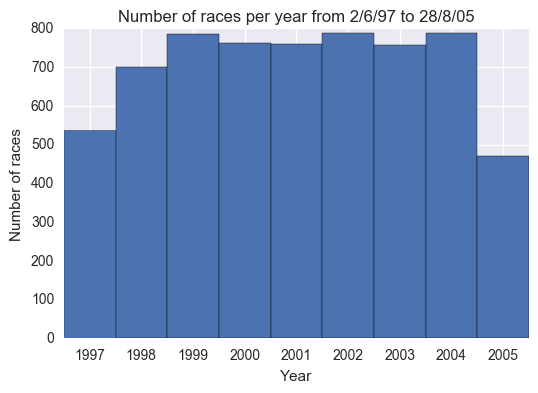

In [369]:
plt.hist(df_races.year,bins=9,range=(1997,2006))
plt.title("Number of races per year from 2/6/97 to 28/8/05")
plt.ylabel("Number of races")
plt.xlabel("Year")
plt.xticks([i+0.5 for i in range(1997,2006,1)],range(1997,2006,1))
plt.show()

We see a fairly consistent number of races every year, apart from in 1997 and 2006 where our dataset terminates with only partial records. Looking at dividends paid out for wins:

In [370]:
df_races.describe()["win_dividend1"]

count    6349.000000
mean       96.096944
std       131.221259
min        10.500000
25%        34.500000
50%        58.500000
75%       105.500000
max      2687.500000
Name: win_dividend1, dtype: float64

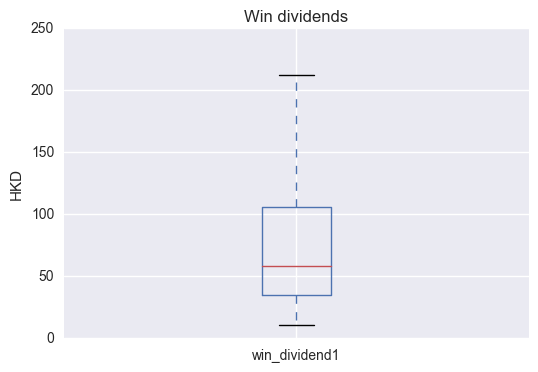

In [371]:
df_races.win_dividend1.plot(kind='box')
plt.title("Win dividends")
plt.ylim(0,250)
plt.ylabel("HKD")

We now look at venue, race track configuration, and track conditions, then get dummies afterwards:

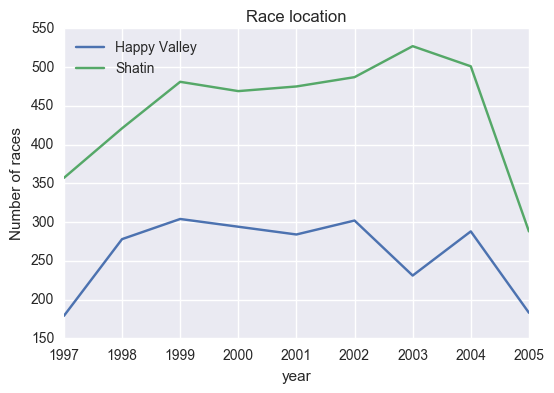

In [372]:
df_races[df_races['venue']=="HV"].groupby(['year'], axis=0).count()['race_id'].plot()
df_races[df_races['venue']=="ST"].groupby(['year'], axis=0).count()['race_id'].plot()
plt.xticks(range(1997,2006,1),range(1997,2006,1))
plt.legend(["Happy Valley","Shatin"], loc='best')
plt.title("Race location")
plt.ylabel("Number of races")
plt.show()

In [373]:
df_races = pd.concat([df_races, pd.get_dummies(df_races['venue'], drop_first=True)], axis=1)
df_races.drop('venue', axis=1, inplace=True)

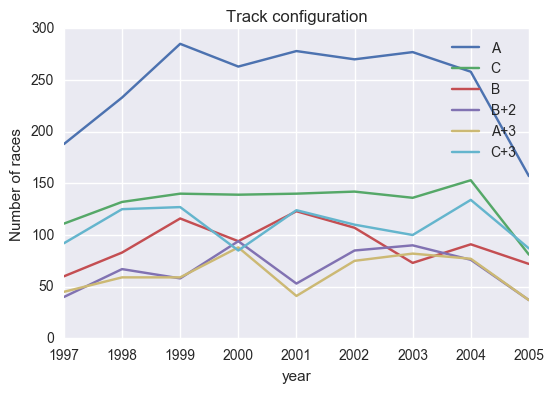

In [374]:
for i in set(df_races.config):
    df_races[df_races['config']==i].groupby(['year'], axis=0).count()['race_id'].plot()
plt.xticks(range(1997,2006,1),range(1997,2006,1))
plt.legend(set(df_races.config), loc='best')
plt.title("Track configuration")
plt.ylabel("Number of races")
plt.show()

In [375]:
df_races = pd.concat([df_races, pd.get_dummies(df_races['config'], drop_first=True, prefix='config')], axis=1)
df_races.drop('config', axis=1, inplace=True)

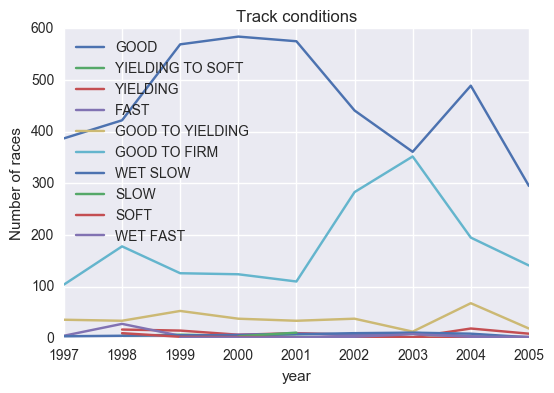

In [376]:
for i in set(df_races.going):
    df_races[df_races['going']==i].groupby(['year'], axis=0).count()['race_id'].plot()
plt.xticks(range(1997,2006,1),range(1997,2006,1))
plt.legend(set(df_races.going), loc='best')
plt.title("Track conditions")
plt.ylabel("Number of races")
plt.show()

In [377]:
df_races = pd.concat([df_races, pd.get_dummies(df_races['going'], drop_first=True)], axis=1)
df_races.drop('going', axis=1, inplace=True)

Horse ratings is evidently quite informative, but it is dropped for the time being since it is encoded in a difficult to interpret format. The next iteration of the project can potentially include this feature after appropriate cleaning:

In [378]:
df_races.drop('horse_ratings', axis=1, inplace=True)

We then look at race classes:

In [379]:
def encode_class(x):
    x = str(x)
    if "1" in x or "One" in x:
        return 1
    elif "2" in x or "Two" in x:
        return 2
    elif "3" in x or "Three" in x:
        return 3
    elif "4" in x or "Four" in x:
        return 4
    elif "5" in x or "Five" in x:
        return 5
    else:
        return 0
    
df_races['racing_class'] = df_races['race_class'].apply(encode_class)

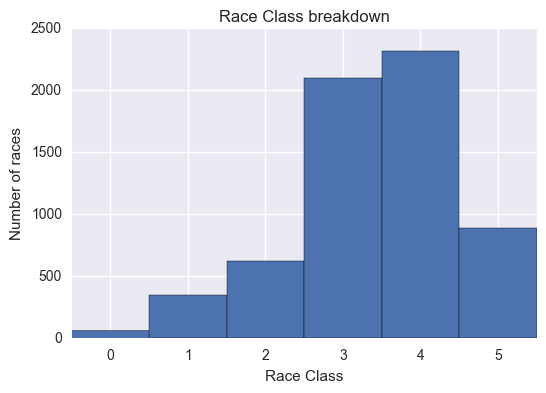

In [380]:
plt.hist(df_races.racing_class, bins=6, range=[0,6])
plt.title("Race Class breakdown")
plt.ylabel("Number of races")
plt.xlabel("Race Class")
plt.xticks([i+0.5 for i in range(0,6,1)], range(0,6,1))
plt.show()

In [381]:
def encode_restrict(x):
    x = str(x)
    if "Restricted" in x:
        return 1
    else:
        return 0

def encode_bonus(x):
    x = str(x)
    if "Bonus" in x:
        return 1
    else:
        return 0
    
df_races['restricted_race'] = df_races['race_class'].apply(encode_restrict)
df_races['bonus_race'] = df_races['race_class'].apply(encode_bonus)
df_races.drop('race_class', axis=1, inplace=True)

Prize money is missing for all races in the period between 20/7/1997 and 18/3/1998 inclusive:

In [382]:
print df_races[df_races.prize.isnull()].date.iloc[0]
print df_races[df_races.prize.isnull()].date.iloc[-1]

1997-07-20 00:00:00
1998-03-18 00:00:00


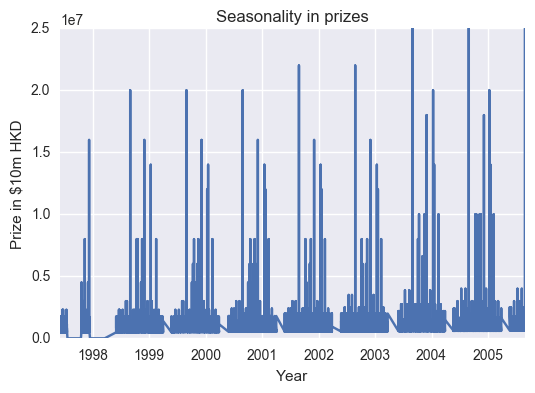

In [383]:
diffy = df_races.copy()
diffy.loc[diffy.prize.isnull(),'prize'] = 0
plt.plot(diffy.date, diffy.prize)
plt.title("Seasonality in prizes")
plt.xlabel("Year")
plt.ylabel("Prize in $10m HKD")
plt.show()

In [384]:
df_races.drop('date', axis=1, inplace=True)

The following columns are dropped because they are not features to be input into the model; in fact most of them can be used a target variable for a regression or classification problem as a stretch goal, which will not be used right now.

In [385]:
drop_list = ['sec_time1', 'sec_time2', 'sec_time3', 'sec_time4', 'sec_time5', 'sec_time6', 'sec_time7',
            'time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 
            'place_combination4', 'place_dividend4', 'win_combination2', 'win_dividend2']
df_races.drop(drop_list, axis=1, inplace=True)

## Run dataset

In [290]:
df_runs = pd.read_csv("assets/hkraces/runs.csv")
pd.set_option('max_columns', len(df_runs.columns))

In [291]:
print df_runs.shape
df_runs.head()

(79447, 38)


,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,horse_rating,horse_gear,declared_weight,actual_weight,draw,position_sec1,position_sec2,position_sec3,position_sec4,position_sec5,position_sec6,behind_sec1,behind_sec2,behind_sec3,behind_sec4,behind_sec5,behind_sec6,time1,time2,time3,time4,time5,time6,time_final,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,60,--,1020.0,133,7,6,4,6,10.0,NaN,NaN,2.00,2.00,1.50,8.00,NaN,NaN,13.85,21.59,23.86,24.62,NaN,NaN,24.62,83.92,9.7,3.7,118,2
1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,60,--,980.0,133,12,12,13,13,8.0,NaN,NaN,6.50,9.00,5.00,5.75,NaN,NaN,14.57,21.99,23.30,23.70,NaN,NaN,23.70,83.56,16.0,4.9,164,57
2,0,3,858,7,0.0,4.75,3,NZ,Gelding,60,--,1082.0,132,8,3,2,2,7.0,NaN,NaN,1.00,1.00,0.75,4.75,NaN,NaN,13.69,21.59,23.90,24.22,NaN,NaN,24.22,83.40,3.5,1.5,137,18
3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,60,--,1118.0,127,13,8,8,11,9.0,NaN,NaN,3.50,5.00,3.50,6.25,NaN,NaN,14.09,21.83,23.70,24.00,NaN,NaN,24.00,83.62,39.0,11.0,80,59
4,0,5,2796,6,0.0,3.75,3,GB,Gelding,60,--,972.0,131,14,13,12,12,6.0,NaN,NaN,7.75,8.75,4.25,3.75,NaN,NaN,14.77,21.75,23.22,23.50,NaN,NaN,23.50,83.24,50.0,14.0,9,154


In [293]:
df_runs.drop(df_runs.columns[-25:-4].tolist(), axis=1, inplace=True)

The Hong Kong Jockey Club's horse races are special in one way: there are few other races in the world where horse breeds from both the Northern hemisphere and Southern hemisphere compete together. Here we see a lot of representation from Australia and New Zealand:

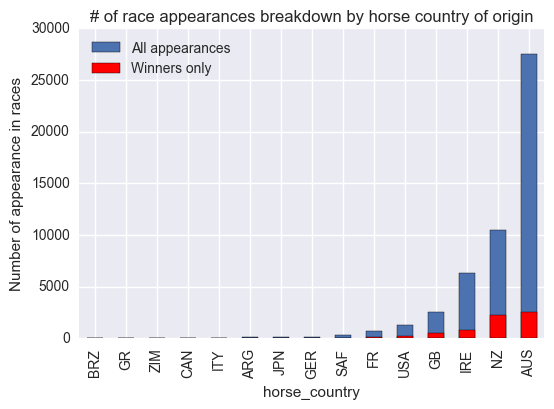

In [294]:
df_runs.groupby(['horse_country'], axis=0).count()['race_id'].sort_values().plot(kind='bar')
df_runs[df_runs["won"]==1].groupby(['horse_country'], axis=0).count()['race_id'].sort_values().plot(kind='bar', color='r')
plt.ylabel("Number of appearance in races")
plt.title("# of race appearances breakdown by horse country of origin")
plt.legend(["All appearances","Winners only"], loc='best')
plt.show()

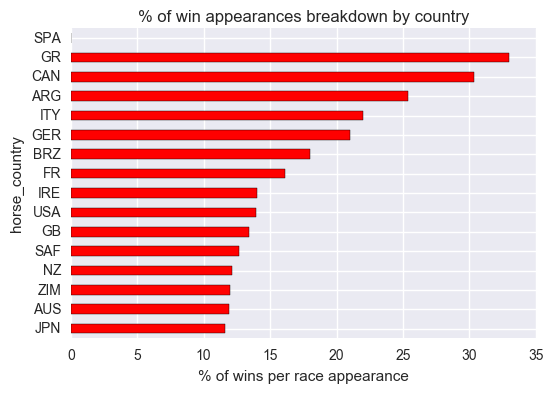

In [295]:
pd.Series(df_runs.groupby(['horse_country'], axis=0).count()['race_id']/
          df_runs[df_runs["won"]==1].groupby(['horse_country'], axis=0).count()['race_id']).sort_values().plot(kind='barh', color='r')
plt.xlabel("% of wins per race appearance")
plt.title("% of win appearances breakdown by country")
plt.show()

Getting dummies for country.

In [296]:
df_runs = pd.concat([df_runs, pd.get_dummies(df_runs.horse_country, drop_first=True)], axis=1)
df_runs.drop('horse_country', axis=1, inplace=True)

We see here that most horses are geldings, then get dummies for this column.

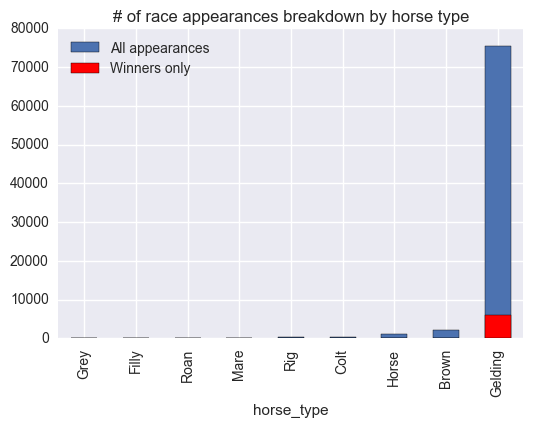

In [297]:
df_runs.groupby(['horse_type'], axis=0).count()['race_id'].sort_values().plot(kind='bar')
df_runs[df_runs["won"]==1].groupby(['horse_type'], axis=0).count()['race_id'].sort_values().plot(kind='bar', color='r')
plt.legend(["All appearances","Winners only"], loc='best')
plt.title("# of race appearances breakdown by horse type")
plt.show()

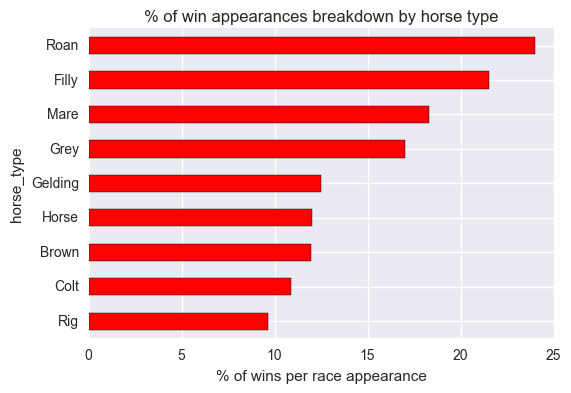

In [298]:
pd.Series(df_runs.groupby(['horse_type'], axis=0).count()['race_id']/df_runs[df_runs["won"]==1].groupby(['horse_type'], axis=0).count()['race_id']).sort_values().plot(kind='barh', color='r')
plt.xlabel("% of wins per race appearance")
plt.title("% of win appearances breakdown by horse type")
plt.show()

In [299]:
df_runs = pd.concat([df_runs, pd.get_dummies(df_runs.horse_type, drop_first=True)], axis=1)
df_runs.drop('horse_type', axis=1, inplace=True)

Encoding horse trainer and jockey id:

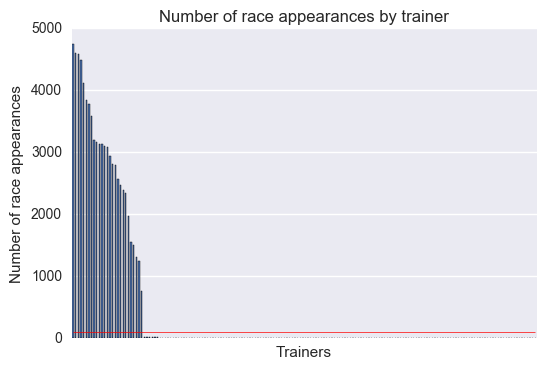

In [335]:
df_runs.groupby(['trainer_id'], axis=0).count()['race_id'].sort_values()[::-1].plot(kind='bar')
plt.xticks([])
plt.title("Number of race appearances by trainer")
plt.ylabel("Number of race appearances")
plt.xlabel("Trainers")
plt.hlines(100,0,175, color='r', lw=0.5)
plt.show()

In [330]:
trainers = df_runs.groupby(['trainer_id'], axis=0).count()['race_id']
trainers[trainers>100]
print "Out of a total of",len(trainers),"trainers,",\
"the percentage of trainers that had more than 100 race appearances (as indicated by the red line) is",\
round(len(trainers[trainers>100])*100/len(trainers),2),"percent."

Out of a total of 176 trainers, the percentage of trainers that had more than 100 race appearances (as indicated by the red line) is 15.34 percent.


In [247]:
df_runs = pd.concat([df_runs, pd.get_dummies(df_runs.trainer_id, drop_first=True, prefix="trainer")], axis=1)
df_runs.drop('trainer_id', axis=1, inplace=True)

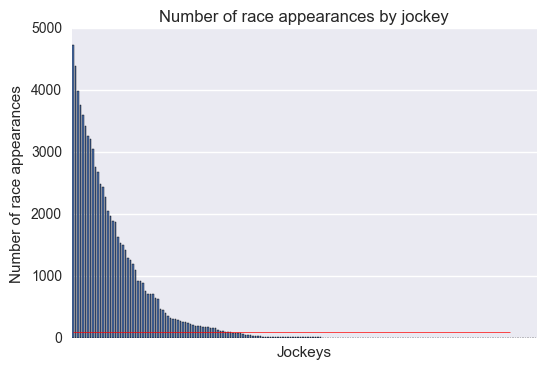

In [336]:
df_runs.groupby(['jockey_id'], axis=0).count()['race_id'].sort_values()[::-1].plot(kind='bar')
plt.xticks([])
plt.title("Number of race appearances by jockey")
plt.ylabel("Number of race appearances")
plt.xlabel("Jockeys")
plt.hlines(100,0,175, color='r', lw=0.5)
plt.show()

In [333]:
jockeys = df_runs.groupby(['jockey_id'], axis=0).count()['race_id']
jockeys[jockeys>100]
print "Out of a total of",len(jockeys),"jockeys,",\
"the percentage of jockeys that had more than 100 race appearances (as indicated by the red line) is",\
round(len(jockeys[jockeys>100])*100/len(jockeys),2),"percent."

Out of a total of 186 jockeys, the percentage of jockeys that had more than 100 race appearances (as indicated by the red line) is 32.8 percent.


In [249]:
df_runs = pd.concat([df_runs, pd.get_dummies(df_runs.jockey_id , drop_first=True, prefix="jockey")], axis=1)
df_runs.drop('jockey_id', axis=1, inplace=True)

We will ignore horse gear for now.

In [250]:
print len(df_runs.horse_gear.value_counts())
df_runs.drop('horse_gear', axis=1, inplace=True)

822


In [251]:
df_runs.drop(['result','lengths_behind'], axis=1, inplace=True)

### Merging datasets

We will merge the two DataFrames on the `race_id` column.

In [252]:
df_runs.head(2)

,race_id,horse_no,horse_id,won,horse_age,horse_rating,declared_weight,actual_weight,win_odds,place_odds,AUS,BRZ,CAN,FR,GB,GER,GR,IRE,ITY,...,jockey_167,jockey_168,jockey_169,jockey_170,jockey_171,jockey_172,jockey_173,jockey_174,jockey_175,jockey_176,jockey_177,jockey_178,jockey_179,jockey_180,jockey_181,jockey_182,jockey_183,jockey_184,jockey_185
0,0,1,3917,0.0,3,60,1020.0,133,9.7,3.7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,2157,0.0,3,60,980.0,133,16.0,4.9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [253]:
df_races.head(2)

,race_id,race_no,surface,distance,prize,place_combination1,place_combination2,place_combination3,place_dividend1,place_dividend2,place_dividend3,win_combination1,win_dividend1,year,month,day,ST,config_A+3,config_B,config_B+2,config_C,config_C+3,GOOD,GOOD TO FIRM,GOOD TO YIELDING,SLOW,SOFT,WET FAST,WET SLOW,YIELDING,YIELDING TO SOFT,racing_class,restricted_race,bonus_race
0,0,1,0,1400,485000.0,8,11,6.0,36.5,25.5,18.0,8,121.0,1997,6,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,0,0
1,1,2,0,1200,485000.0,5,13,4.0,12.5,47.0,33.5,5,23.5,1997,6,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,0,0


In [254]:
df_model = pd.merge(df_runs, df_races, how='inner', left_on='race_id', right_on='race_id')

In [255]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79447 entries, 0 to 79446
Columns: 426 entries, race_id to bonus_race
dtypes: float64(10), int64(18), uint8(398)
memory usage: 47.7 MB


## Unsupervised Machine Learning

### Principal Components Analysis

In [256]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [257]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df_model.dropna(axis=0, how='any'))

In [258]:
N=10
pca = PCA(n_components=N)
pca.fit_transform(df_scaled)
print sum(pca.explained_variance_ratio_), "of the variance is explained using", N, "components."

0.0626457740306 of the variance is explained using 10 components.


In [259]:
N=100
pca = PCA(n_components=N)
pca.fit_transform(df_scaled)
print sum(pca.explained_variance_ratio_), "of the variance is explained using", N, "components."

0.421745245652 of the variance is explained using 100 components.


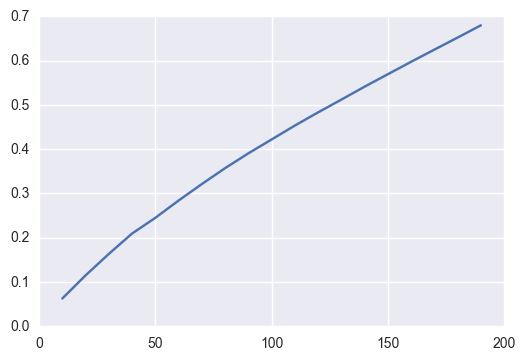

In [338]:
pca_explained = []
for i in range(10,200,10):
    N=i
    pca = PCA(n_components=N)
    pca.fit_transform(df_scaled)
    #print sum(pca.explained_variance_ratio_), "of the variance is explained using", N, "components."
    pca_explained.append(sum(pca.explained_variance_ratio_))
plt.plot(range(10,200,10), pca_explained)

A naive approach of dimensionality reduction of all possible (scaled and centred) features using PCA does not perform well as measured by the cumulative explained variance ratio. Even with an excessive 100 principal components only explains 42% of the variance.

## Target variable

In [38]:
print df_model.shape
"""
df_model.dropna(how='any', axis=1, inplace=True)
print df_model.shape
"""

(79447, 426)


"\ndf_model.dropna(how='any', axis=1, inplace=True)\nprint df_model.shape\n"

In [39]:
y = df_model.won
print y.shape
print y.value_counts()

(79447,)
0.0    73087
1.0     6360
Name: won, dtype: int64


In [40]:
X = df_model.drop('won', axis=1)

In [41]:
X.describe().loc['count'].sort_values()[:10]

prize                 73598.0
place_odds            75712.0
place_dividend3       79307.0
place_combination3    79307.0
jockey_83             79447.0
jockey_82             79447.0
jockey_81             79447.0
jockey_80             79447.0
jockey_79             79447.0
jockey_78             79447.0
Name: count, dtype: float64

We'll also drop prize and the other columns with missing values for now. A strategy for imputing these values will be devised later.

In [42]:
X = X.dropna(axis=1, how='any')

In [43]:
X.describe().loc['count'].sort_values()[:10]

race_id      79447.0
jockey_81    79447.0
jockey_80    79447.0
jockey_79    79447.0
jockey_78    79447.0
jockey_77    79447.0
jockey_76    79447.0
jockey_75    79447.0
jockey_74    79447.0
jockey_73    79447.0
Name: count, dtype: float64

In [44]:
pd.set_option('max_columns', X.shape[1])
X.head(2)

,race_id,horse_no,horse_id,horse_age,horse_rating,declared_weight,actual_weight,win_odds,AUS,BRZ,CAN,FR,GB,GER,GR,IRE,ITY,JPN,NZ,SAF,SPA,USA,ZIM,Colt,Filly,Gelding,Grey,Horse,Mare,Rig,Roan,trainer_1,trainer_2,trainer_3,trainer_4,trainer_5,trainer_6,trainer_7,trainer_8,trainer_9,trainer_10,trainer_11,trainer_12,trainer_13,trainer_14,trainer_15,trainer_16,trainer_17,trainer_18,trainer_19,trainer_20,trainer_21,trainer_22,trainer_23,trainer_24,trainer_25,trainer_26,trainer_27,trainer_28,trainer_29,trainer_30,trainer_31,trainer_32,trainer_33,trainer_34,trainer_35,trainer_36,trainer_37,trainer_38,trainer_39,trainer_40,trainer_41,trainer_42,trainer_43,trainer_44,trainer_45,trainer_46,trainer_47,trainer_48,trainer_49,trainer_50,trainer_51,trainer_52,trainer_53,trainer_54,trainer_55,trainer_56,trainer_57,trainer_58,trainer_59,trainer_60,trainer_61,trainer_62,trainer_63,trainer_64,trainer_65,trainer_66,trainer_67,trainer_68,trainer_69,trainer_70,trainer_71,trainer_72,trainer_73,trainer_74,trainer_75,trainer_76,trainer_77,trainer_78,trainer_79,trainer_80,trainer_81,trainer_82,trainer_83,trainer_84,trainer_85,trainer_86,trainer_87,trainer_88,trainer_89,trainer_90,trainer_91,trainer_92,trainer_93,trainer_94,trainer_95,trainer_96,trainer_97,trainer_98,trainer_99,trainer_100,trainer_101,trainer_102,trainer_103,trainer_104,trainer_105,trainer_106,trainer_107,trainer_108,trainer_109,trainer_110,trainer_111,trainer_112,trainer_113,trainer_114,trainer_115,trainer_116,trainer_117,trainer_118,trainer_119,trainer_120,trainer_121,trainer_122,trainer_123,trainer_124,trainer_125,trainer_126,trainer_127,trainer_128,trainer_129,trainer_130,trainer_131,trainer_132,trainer_133,trainer_134,trainer_135,trainer_136,trainer_137,trainer_138,trainer_139,trainer_140,trainer_141,trainer_142,trainer_143,trainer_144,trainer_145,trainer_146,trainer_147,trainer_148,trainer_149,trainer_150,trainer_151,trainer_152,trainer_153,trainer_154,trainer_155,trainer_156,trainer_157,trainer_158,trainer_159,trainer_160,trainer_161,trainer_162,trainer_163,trainer_164,trainer_165,trainer_166,trainer_167,trainer_168,trainer_169,trainer_170,trainer_171,trainer_172,trainer_173,trainer_174,trainer_175,jockey_1,jockey_2,jockey_3,jockey_4,jockey_5,jockey_6,jockey_7,jockey_8,jockey_9,jockey_10,jockey_11,jockey_12,jockey_13,jockey_14,jockey_15,jockey_16,jockey_17,jockey_18,jockey_19,jockey_20,jockey_21,jockey_22,jockey_23,jockey_24,jockey_25,jockey_26,jockey_27,jockey_28,jockey_29,jockey_30,jockey_31,jockey_32,jockey_33,jockey_34,jockey_35,jockey_36,jockey_37,jockey_38,jockey_39,jockey_40,jockey_41,jockey_42,jockey_43,jockey_44,jockey_45,jockey_46,jockey_47,jockey_48,jockey_49,jockey_50,jockey_51,jockey_52,jockey_53,jockey_54,jockey_55,jockey_56,jockey_57,jockey_58,jockey_59,jockey_60,jockey_61,jockey_62,jockey_63,jockey_64,jockey_65,jockey_66,jockey_67,jockey_68,jockey_69,jockey_70,jockey_71,jockey_72,jockey_73,jockey_74,jockey_75,jockey_76,jockey_77,jockey_78,jockey_79,jockey_80,jockey_81,jockey_82,jockey_83,jockey_84,jockey_85,jockey_86,jockey_87,jockey_88,jockey_89,jockey_90,jockey_91,jockey_92,jockey_93,jockey_94,jockey_95,jockey_96,jockey_97,jockey_98,jockey_99,jockey_100,jockey_101,jockey_102,jockey_103,jockey_104,jockey_105,jockey_106,jockey_107,jockey_108,jockey_109,jockey_110,jockey_111,jockey_112,jockey_113,jockey_114,jockey_115,jockey_116,jockey_117,jockey_118,jockey_119,jockey_120,jockey_121,jockey_122,jockey_123,jockey_124,jockey_125,jockey_126,jockey_127,jockey_128,jockey_129,jockey_130,jockey_131,jockey_132,jockey_133,jockey_134,jockey_135,jockey_136,jockey_137,jockey_138,jockey_139,jockey_140,jockey_141,jockey_142,jockey_143,jockey_144,jockey_145,jockey_146,jockey_147,jockey_148,jockey_149,jockey_150,jockey_151,jockey_152,jockey_153,jockey_154,jockey_155,jockey_156,jockey_157,jockey_158,jockey_159,jockey_160,jockey_161,jockey_162,jockey_163,jockey_164,jockey_165,jockey_166,jockey_167,jockey_168,jockey_169,jockey_170,jockey_171,jockey_172,jockey_173,jockey_174,jockey_175,jo

In [45]:
drop_list = ['place_combination1', 'place_combination2', 'place_dividend1', 'place_dividend2', 'win_combination1', 'win_dividend1']
X.drop(drop_list, axis=1, inplace=True)

### Risks & Assumptions

The primary concern with this dataset is that although it spans records from 1997 to 2006 covering 6000+ races and can therefore be **assumed to be reasonably representative of horse racing conditions in Hong Kong**, there is the **risk of unknown changes in the intervening period from 2006 to the present day that may materially affect our model's accuracy of prediction in the present day**. Possible factors may include changes in track conditions, changes in horse rearing and training practices, climate change affecting horse performance etc.

Another potential source of risk is that **HKJC's method of calculating winning odds may have changed, either during the period of 1997-2006 recorded in this dataset and/or in the present day.** If either of these scenarios have occurred, then our calculation of betting gains/losses may have little use in predicting the monetary return of using this model in real life. The **assumption is thus made that HKJC's odds calculation method has not changed sufficiently to drastically affect our estimation of betting gains and losses using our model**. Nevertheless, in drawing our conclusions, we should keep this in mind and interpret the predicted percentage gain/loss only as an indicator.

A third problem could affect our ability to put the trained model into production. We have implicitly made the **assumption that we can obtain the same features as the ones that we have in current dataset, from either the HKJC website or other sources for present day races.** The **risk is that we won't be able to put our model into production due to a change in availability and/or reporting methodology of key features.** This should be verified as a follow-up if the viability of the project is proved.

One final issue that needs to be raised is this: though we have opted to anonymise the individual horses by dropping the `horse_id` column, we have kept the `trainer_id` and `jockey_id` information and one-hot encoded them. **It remains to be investigated how correlated these features are.** If they are highly correlated, then the individual horses may not have been effectively de-anonymised; on the other hand, these may turn out to be very important features that are essential for good model predictions. The choice to de-anonymise was made to try and make our predictions *more generalisable* - we can potentially use the model to assess new horses without a track record. **This decision is open to revision depending on more EDA findings and model results.**

## Modelling - Supervised Learning

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### Imbalanced dataset

Since there are 12 horses competing and every race and only 1 can be the winner, we end up with a very imbalanced dataset for classification, with a win:lose ratio of 1:11.

In [48]:
y.value_counts()

0.0    73087
1.0     6360
Name: won, dtype: int64

In [49]:
y.value_counts()[0]/(y.value_counts()[0]+y.value_counts()[1])

0.91994663108739161

**This ratio will also be our baseline**: we want a model that can predict wins, not just losses.

### Randomly oversampling wins

In order to combat this, we use oversampling to improve the training of our models. Prior to this, most models would just default to predicting losses.

In [50]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [51]:
print X_train.shape
print X_resampled.shape
print y_train.shape
print y_resampled.shape

(55612, 415)
(102320, 415)
(55612,)
(102320,)


In [52]:
pd.Series(y_resampled).value_counts()

1.0    51160
0.0    51160
dtype: int64

### Logistic Regression

We start off our trial and error process with the most basic logistic regression model.

In [67]:
lr = LogisticRegression()
lr.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
scores = cross_val_score(lr, X_resampled,y_resampled, cv=5)
scores.mean(), scores.std()

(0.69939405785770137, 0.0007864894268463994)

The 5-fold cross validation accuracy score is lower than our baseline. The model fares even worse when used on the test set:

In [92]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.59223830501363539

In [70]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.97      0.57      0.72     21927
        1.0       0.14      0.81      0.24      1908

avg / total       0.90      0.59      0.68     23835



In [71]:
pd.Series(y_pred).value_counts()

0.0    12952
1.0    10883
dtype: int64

In [72]:
roc_auc_score(y_test,y_pred)

0.68937667096050281

After ranking the coefficients of individual features, we see that **the most important features are jockey and train id** in our logistic regression model.

In [73]:
lr_coef = pd.DataFrame(lr.coef_, columns=X.columns)
lr_coef.columns = X.columns
lr_coef.index = ['coefs']
lr_coef.transpose().sort_values(by='coefs')[:15]

,coefs
jockey_86,-2.092544
jockey_168,-1.767624
jockey_74,-1.722818
GR,-1.601653
jockey_136,-1.482365
jockey_146,-1.454229
jockey_113,-1.318582
Grey,-1.262388
jockey_103,-1.210452
jockey_152,-1.189799


### Calculating payout

In [93]:
print y_pred.shape
pd.Series(y_pred).value_counts()

(23835,)


0.0    12952
1.0    10883
dtype: int64

In [94]:
pd.Series(y_test).value_counts()

0.0    21927
1.0     1908
Name: won, dtype: int64

To simplify the calculation, we assume an initial pot of money of \$10883. Since our model predicts 5356 instances of winning, we will bet \$1 on each predicted win.

In [98]:
# True Positives only
correct_pred = y_pred * y_test
pd.Series(correct_pred).value_counts()

0.0    22299
1.0     1536
Name: won, dtype: int64

In [99]:
sum(X_test.win_odds * correct_pred)

8802.2999999999993

In [100]:
sum(X_test.win_odds * correct_pred)/10883

0.80881190848111728

We then turn to ensemble methods to see if there's an improvement.

### Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
rfc = RandomForestClassifier()
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [101]:
y_pred = rfc.predict(X_test)

In [102]:
accuracy_score(y_test, y_pred)

0.91432766939374865

In [78]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.92      0.99      0.96     21927
        1.0       0.27      0.04      0.07      1908

avg / total       0.87      0.91      0.88     23835



In [103]:
roc_auc_score(y_test,y_pred)

0.51512752578381149

### Calculating payout

In [104]:
print y_pred.shape
pd.Series(y_pred).value_counts()

(23835,)


0.0    23549
1.0      286
dtype: int64

In [105]:
pd.Series(y_test).value_counts()

0.0    21927
1.0     1908
Name: won, dtype: int64

To simplify the calculation, we assume an initial pot of money of \$286. Since our model predicts 286 instances of winning, we will bet \$1 on each predicted win.

In [106]:
# True Positives only
correct_pred = y_pred * y_test
pd.Series(correct_pred).value_counts()

0.0    23759
1.0       76
Name: won, dtype: int64

In [107]:
sum(X_test.win_odds * correct_pred)

215.40000000000006

In [108]:
sum(X_test.win_odds * correct_pred)/286

0.75314685314685337

### Gradient Boosting Classifier

Here we use another ensemble method, but using Boosting instead of Random Forests.

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

In [81]:
gbc = GradientBoostingClassifier()
gbc.fit(X_resampled, y_resampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [109]:
y_pred = gbc.predict(X_test)

In [83]:
accuracy_score(y_test, y_pred)

0.72481644640234943

In [84]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.96      0.73      0.83     21927
        1.0       0.18      0.69      0.29      1908

avg / total       0.90      0.72      0.79     23835



In [85]:
roc_auc_score(y_test,y_pred)

0.70832010332742179

### Calculating payout

In [110]:
print y_pred.shape
pd.Series(y_pred).value_counts()

(23835,)


0.0    16556
1.0     7279
dtype: int64

In [111]:
pd.Series(y_test).value_counts()

0.0    21927
1.0     1908
Name: won, dtype: int64

To simplify the calculation, we assume an initial pot of money of \$7279. Since our model predicts 7279 instances of winning, we will bet \$1 on each predicted win.

In [112]:
# True Positives only
correct_pred = y_pred * y_test
pd.Series(correct_pred).value_counts()

0.0    22521
1.0     1314
Name: won, dtype: int64

In [113]:
sum(X_test.win_odds * correct_pred)

6158.4000000000024

In [114]:
sum(X_test.win_odds * correct_pred)/7279

0.84605028163209262

### XGBClassifier

In [86]:
from xgboost import XGBClassifier

In [87]:
clf = XGBClassifier()
clf.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='binary:logistic', seed=0,
       silent=True, subsample=1)

In [115]:
y_pred = clf.predict(X_test)

In [116]:
accuracy_score(y_test, y_pred)

0.72431298510593667

In [90]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.96      0.73      0.83     21927
        1.0       0.18      0.69      0.29      1908

avg / total       0.90      0.72      0.79     23835



In [91]:
roc_auc_score(y_test,y_pred)

0.70780721651288303

### Calculating payout

In [117]:
print y_pred.shape
pd.Series(y_pred).value_counts()

(23835,)


0.0    16546
1.0     7289
dtype: int64

In [118]:
pd.Series(y_test).value_counts()

0.0    21927
1.0     1908
Name: won, dtype: int64

To simplify the calculation, we assume an initial pot of money of \$7289. Since our model predicts 7289 instances of winning, we will bet \$1 on each predicted win.

In [119]:
# True Positives only
correct_pred = y_pred * y_test
pd.Series(correct_pred).value_counts()

0.0    22522
1.0     1313
Name: won, dtype: int64

In [120]:
sum(X_test.win_odds * correct_pred)

6146.0000000000027

In [121]:
sum(X_test.win_odds * correct_pred)/7289

0.843188366031006

### XGBClassifier: tuning hyperparameters

In [54]:
clf2 = XGBClassifier(n_estimators=400, max_depth=8, learning_rate=0.05)
clf2.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=400, nthread=-1, objective='binary:logistic', seed=0,
       silent=True, subsample=1)

In [126]:
y_pred = clf2.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.78292427102999795

In [57]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.95      0.80      0.87     21927
        1.0       0.20      0.55      0.29      1908

avg / total       0.89      0.78      0.83     23835



In [58]:
roc_auc_score(y_test,y_pred)

0.67554349868187558

After dropping the columns from the design matrix that turned out not to be features after all, the performance of models dropped across the board. So far it seems that the bookies cannot be beat consistently. 

xgboost is an implementation of Gradient Boosting which is very popular on Kaggle competitions due to its speed and good performance, which is amply demonstrated here. However, in some respects it is a bit of a black box: although xgboost nominally implements the same algorithm as the Gradient Boosting Classifier in sklearn, it has been noted by several Kaggle competitors that xgboost trains models differently and its results cannot be reproduced with other implementations on either sklearn or R.

In [118]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

### Pickling

In [78]:
import pickle
pickle.dump(clf2, open("best_xgbclassifier_trained_check.pickle.dat", "wb"))

We can later use `loaded_model = pickle.load(open("best_xgbclassifier_trained.pickle.dat", "rb"))` to load our trained model.

In [79]:
loaded_model = pickle.load(open("best_xgbclassifier_trained_check.pickle.dat", "rb"))

In [83]:
loaded_model.get_xgb_params()

{'base_score': 0.5,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 400,
 'objective': 'binary:logistic',
 'seed': 0,
 'silent': 1,
 'subsample': 1}

### Calculating payout

In [127]:
print y_pred.shape
pd.Series(y_pred).value_counts()

(23835,)


0.0    18479
1.0     5356
dtype: int64

In [128]:
pd.Series(y_test).value_counts()

0.0    21927
1.0     1908
Name: won, dtype: int64

To simplify the calculation, we assume an initial pot of money of \$5356. Since our model predicts 5356 instances of winning, we will bet \$1 on each predicted win.

In [129]:
# True Positives only
correct_pred = y_pred * y_test
pd.Series(correct_pred).value_counts()

0.0    22790
1.0     1045
Name: won, dtype: int64

In [130]:
sum(X_test.win_odds * correct_pred)

4562.300000000002

In [133]:
sum(X_test.win_odds * correct_pred)/5356

0.85181105302464566

## Executive Summary

A dataset on 6000+ historical Hong Kong Jockey Club horse races from 1997 to 2016 was obtained through public sources and processed to extract relevant features for predictive modelling of racing wins. Such features included race track location, condition, horse, jockey and trainer information.

Exploratory Data Analysis revealed certain facts:

- Although the country with the most race appearances were Australia and New Zealand by a large margin, by win percentage they were quite poorly performing, with horses from Greece, Canada and Argentina having the highest win percentages.
- The number of race appearances by jockeys followed a Pareto distribution.
- Prize money exhibited strong seasonality, corresponding with scheduled high-profile events and competitions.
- The vast majority (exceeding 90%) of all competing horse appearances were by Geldings.

These observations must be balanced by the fact that our best predictive models were not able to predict consistently accurately enough to overcome the large betting margin enjoyed by the Hong Kong Jockey Club, in part due to its status as a legal monopoly for gambling. The following Machine Learning models were trained and tested on the data:

- Logistic Regression
- Random Forest Classifer
- Gradient Boosting Classifer

Model selection based on accuracy score, ROC AUC score and Precision/Recall was performed. The highest performing model was determined to be the Gradient Boosting Classifier. However, calculating the payout based on betting with the model's predictions resulted in an overall loss of 15% over time.

Based on these results, it is determined that continuing to try and predict wins consistently has a very low likelihood of success for making money.

## Discussion of model selection and implementation

A rather straightforward approach was taken with model selection, which had the advantage of being easy and quick to implement:

- 70:30 Train/Test split of the dataset
- Random Oversampling of wins to mitigate the fact that the target variable (wins) was highly imbalanced (~1:11)
- Modelling with Logistic Regression, Random Forest Classifer and Gradient Boosting Classifier on the training set
- Applying each model on the test set
- Model valuation using Accuracy score, ROC AUC score and Precision/Recall 

This workflow helped us quickly see that even our best models were far from our goal of beating the bookies' generous betting margins, thereby allowing us to quickly assess that continuing with the project would have a very low likelihood of succeeding. In a commercial setting, this approach has the value of allowing us to assess projects rapidly, and cut off less productive ones to free up resources for other pursuits.

If the results had turned out to be more promising and thus worthy of additional time investment, then a number of improvements could be made to the model selection and implementation process:

- Split the data into Train/Validation/Test sets (60:20:20) then apply nested cross validation on each Machine Learning algorithm
- Plot learning curves, ROC curves etc. and make explicit the performance differences and model selection criteria
- Retrain the highest performing model on the Train+Validation set for better generalisation

## Stakeholder recommendations and next steps

Based on the fact that the predictive ability of our models at this stage are significantly below what would be needed to consistently beat the generous betting margins of HKJC due to its legal monopoly in Hong Kong, the recommendation to stakeholders would be that **continuing to try and predict wins consistently has a very low likelihood of success. Further effort into improving the data gathering, feature engineering and modelling process would very likely not be a worthy time investment.**

However, the option is open for stakeholders to decide if other betting pools such as Place, Quinella, Trio etc. are worthy of investigation. Although this avenue was not explored, the fact remains that HKJC is allowed to enjoy very high betting margins due to its legal monopoly, and thus it would be reasonable to argue that any predictive model would probably have to be exceptionally high performing to be able to make predictions consistently and accurately enough to make money for the bettors.